In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from classificatiom_model import EarlyStopping, ModelSaver
from classificatiom_model import plot_learning_curves,plot_learning_loss_curves
import torch.nn.functional as F

In [3]:
# 加载加利福尼亚房价数据集
housing = fetch_california_housing()  # 从sklearn加载加利福尼亚房价数据集
X = housing.data  # 获取特征数据
y = housing.target  # 获取目标变量（房价）

# 数据拆分：训练集(60%)、验证集(20%)、测试集(20%)
# 首先将数据分为训练集(80%)和测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 使用80%/20%的比例划分训练验证集和测试集

# 然后将训练集再分为训练集(75%，即总数据的60%)和验证集(25%，即总数据的20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 将训练验证集进一步划分为训练集和验证集

# 打印数据集大小
print(f"训练集大小: {X_train.shape[0]} 样本")  # 显示训练集样本数量
print(f"验证集大小: {X_val.shape[0]} 样本")  # 显示验证集样本数量
print(f"测试集大小: {X_test.shape[0]} 样本")  # 显示测试集样本数量

# 标准化特征
scaler = StandardScaler()  # 创建标准化转换器
X_train_scaled = scaler.fit_transform(X_train)  # 对训练集进行拟合和转换
X_val_scaled = scaler.transform(X_val)  # 使用训练集的参数对验证集进行转换
X_test_scaled = scaler.transform(X_test)  # 使用训练集的参数对测试集进行转换


# %% cell 3 code

# 自定义数据集类
class HousingDataset(Dataset):
    """
    加利福尼亚房价数据集的PyTorch数据集类
    
    参数:
        features: 特征数据
        targets: 目标值
        wide_indices: 用于wide部分的特征索引
        deep_indices: 用于deep部分的特征索引
    """
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)  # 将特征转换为PyTorch张量
        self.targets = torch.FloatTensor(targets).view(-1, 1)  # 确保目标是二维的
    
    def __len__(self):
        return len(self.features)  # 返回数据集的大小
    
    def __getitem__(self, idx):
        # 返回wide特征、deep特征和目标值
        return self.features[idx], self.targets[idx]  # 返回指定索引的特征和目标

# 创建数据集实例
# 这里我们假设所有特征都用于wide和deep部分
train_dataset = HousingDataset(X_train_scaled, y_train)  # 创建训练数据集
val_dataset = HousingDataset(X_val_scaled, y_val)  # 创建验证数据集
test_dataset = HousingDataset(X_test_scaled, y_test)  # 创建测试数据集

# 创建数据加载器
batch_size = 64  # 设置批次大小
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 创建训练数据加载器，打乱数据
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # 创建验证数据加载器
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # 创建测试数据加载器

# 检查数据加载器是否正常工作
sample_batch = next(iter(train_loader))  # 获取一个批次的样本
print(f"批次中的特征形状: {[x.shape for x in sample_batch[0]]}")  # 打印特征的形状
print(f"批次中的目标形状: {sample_batch[1].shape}")  # 打印目标的形状


训练集大小: 12384 样本
验证集大小: 4128 样本
测试集大小: 4128 样本
批次中的特征形状: [torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Size([8]), torch.Si

In [4]:
# 自定义线性层
import math  # 导入math模块，用于数学计算

class CustomLinear(nn.Module):
    """
    自定义线性层，实现 y = xW^T + b 的线性变换
    
    参数:
        in_features: 输入特征的数量
        out_features: 输出特征的数量
        bias: 是否使用偏置项，默认为True
    """
    def __init__(self, in_features, out_features, bias=True):
        super(CustomLinear, self).__init__()  # 调用父类的初始化方法
        self.in_features = in_features  # 存储输入特征维度
        self.out_features = out_features  # 存储输出特征维度
        
        # 创建权重参数，使用nn.Parameter使其可以被优化
        # 形状为(out_features, in_features)的张量
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        
        if bias:
            # 如果使用偏置，创建形状为(out_features)的偏置参数
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            # 如果不使用偏置，将bias注册为None
            self.register_parameter('bias', None)
            
        # 初始化参数
        self.reset_parameters()
        
    def reset_parameters(self):
        # 使用与nn.Linear相同的初始化方法
        # kaiming_uniform_初始化权重，适合ReLU激活函数
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            # 计算输入特征数量(fan_in)
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            # 根据fan_in计算均匀分布的边界
            bound = 1 / math.sqrt(fan_in)
            # 使用均匀分布初始化偏置
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, input):
        # 实现前向传播
        # 矩阵乘法：input与weight的转置相乘
        output = torch.matmul(input, self.weight.t())
        if self.bias is not None:
            # 如果有偏置，加到输出上
            output += self.bias
        return output

In [6]:
# 定义神经网络模型
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 30)
        self.activation = nn.ReLU()
        self.output = nn.Linear(30, 1)
        
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.output(x)
        return x

# 初始化模型、损失函数和优化器
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# 打印模型结构
print(model)

RegressionModel(
  (layer1): Linear(in_features=8, out_features=30, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=30, out_features=1, bias=True)
)


In [7]:
# 评估模型
def evaluate_regression_model(model, dataloader,  device,criterion):
    model.eval()
    running_loss = 0.0

    
    with torch.no_grad():#禁止 autograd 记录计算图，节省显存与算力。
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) #前向计算
            loss = criterion(outputs, targets) #计算损失
            
            running_loss += loss.item() * inputs.size(0)
    
    return running_loss / len(dataloader.dataset)

In [8]:
# 定义回归模型训练函数
def train_regression_model(model, train_loader, val_loader, criterion, optimizer, 
                          num_epochs=100, print_every=10, eval_step=100,
                          early_stopping=None, model_saver=None, device="cpu"):
    # 将模型移至指定设备
    model.to(device)
    # 记录训练和验证过程中的损失
    record_dict = {"train": [], "val": []}
    # 初始化最佳验证损失为无穷大
    best_val_loss = float('inf')
    # 初始化全局步数
    global_step = 0
    # 初始化验证损失
    epoch_val_loss = float('inf')
    
    # 创建一个总进度条，显示所有epoch的进度
    total_iterations = num_epochs * len(train_loader)
    pbar = tqdm(total=total_iterations, desc="训练进度")
    
    # 遍历每个训练周期
    for epoch_id in range(num_epochs):
        # 设置模型为训练模式
        model.train()
        # 初始化当前周期的训练损失
        epoch_train_loss = 0.0
        
        # 遍历训练数据
        for inputs, targets in train_loader:
            # 将数据移至指定设备
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失
            loss = criterion(outputs, targets)
            
            # 反向传播
            loss.backward()
            
            # 更新参数
            optimizer.step()
            
            # 累加训练损失
            epoch_train_loss += loss.item()
            
            # 更新全局步数
            global_step += 1
            
            # 记录训练数据
            record_dict["train"].append({
                "loss": loss.item(),
                "step": global_step
            })
            
            # 验证
            if global_step % eval_step == 0:
                epoch_val_loss = evaluate_regression_model(model, val_loader, device, criterion)
            
                # 记录验证数据
                record_dict["val"].append({
                    "loss": epoch_val_loss, 
                    "step": global_step
                })
                
                # 如果有模型保存器，保存模型
                if model_saver is not None:
                    model_saver(model, -epoch_val_loss, epoch_id)
                
                # 如果有早停器，检查是否应该早停
                if early_stopping is not None:
                    early_stopping(-epoch_val_loss)
                    if early_stopping.early_stop:
                        print(f'早停: 已有{early_stopping.patience}轮验证损失没有改善！')
                        pbar.close()
                        return model, record_dict
            
            # 更新进度条
            pbar.update(1)
            pbar.set_postfix({
                "epoch": f"{epoch_id+1}/{num_epochs}", 
                "loss": f"{epoch_train_loss/len(train_loader):.4f}", 
                "val_loss": f"{epoch_val_loss:.4f}"
            })
    
    pbar.close()
    return model, record_dict


In [9]:
# 训练模型
# 初始化早停和模型保存对象
early_stopping = EarlyStopping(patience=10, verbose=True)
model_saver = ModelSaver(save_dir='model_weights')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, record_dict = train_regression_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    print_every=10,
    eval_step=500,
    early_stopping=early_stopping,
    model_saver=model_saver,
    device=device.type
)

训练进度:   0%|          | 0/19400 [00:00<?, ?it/s]

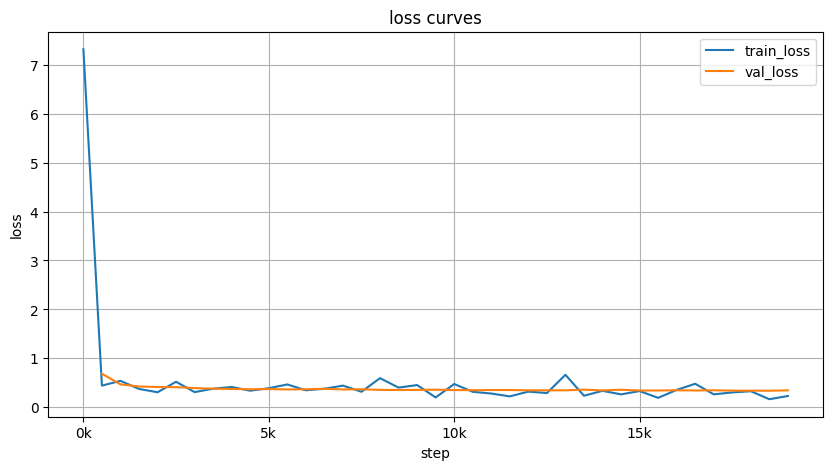

In [10]:
#画图
plot_learning_loss_curves(record_dict,sample_step=500)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_regression_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.3307
